In [1]:
student_id = '20221555'
model_name = 'SINet'

In [2]:
from competition_utils import *
from training_args import *

model_name = f'submission_{model_name}'
module_path = f"models.submission_{student_id}.{model_name}"
module = importlib.import_module(module_path)
globals()[model_name] = getattr(module, model_name)

Project_Name = 'Competition'
model_dir = 'models'
output_root = 'output'

SAVE_RESULT = True
SAVE_N = 1500
vis_root = f'vis/TEST_OUTPUTS_{datetime.now().strftime("%y%m%d_%H%M%S")}'

Dataset_root = 'Datasets'
Dataset_Name_list = [
                     'VOC',
                     'ETIS',
                     'CVPPP',
                     'CFD',
                     'CarDD',
]
number_of_classes_dict = {'VOC':21,
                          'ETIS':2,
                          'CVPPP':2,
                          'CFD':2,
                          'CarDD':2
                         }
epochs = 30
EARLY_STOP = 100
batch_size = 16
EXCLUDE_BACKGROUND = True
BINARY_SEG = None
THRESHOLD = 0.5
device = "cuda" if torch.cuda.is_available() else "cpu"

=== Learning Rate 변화 분석 시작 ===
📊 Learning Rate 변화 계산 중...
✅ 30 epoch 동안의 Learning Rate 변화 계산 완료


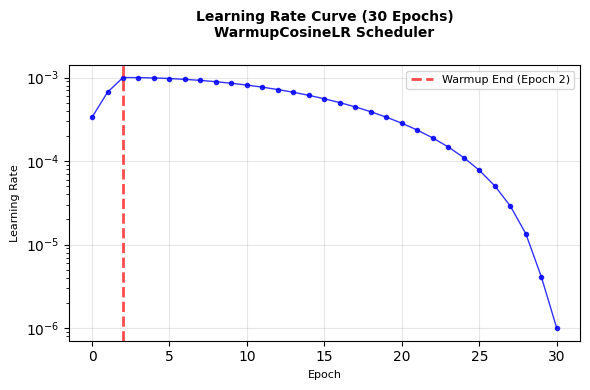


✅ Learning Rate 분석 완료!


In [3]:
# ==================== Learning Rate 변화 추적 및 시각화 ====================
import matplotlib.pyplot as plt
import numpy as np
import torch

print("=== Learning Rate 변화 분석 시작 ===")

# 더미 모델과 옵티마이저 생성 (실제 학습 설정과 동일하게)
print("📊 Learning Rate 변화 계산 중...")

class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Linear(1, 1)
    def parameters(self):
        return [torch.nn.Parameter(torch.zeros(1))]

dummy_model = DummyModel()
optimizer = Make_Optimizer(dummy_model)
lr_scheduler = Make_LR_Scheduler(optimizer)

# 30 epoch 동안의 learning rate 변화 기록
epochs_list = []
lr_values = []

# 초기 learning rate 기록
current_lr = optimizer.param_groups[0]['lr']
epochs_list.append(0)
lr_values.append(current_lr)

# 각 epoch마다 scheduler step 실행하며 learning rate 기록
for epoch in range(1, epochs + 1):
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs_list.append(epoch)
    lr_values.append(current_lr)

print(f"✅ {epochs} epoch 동안의 Learning Rate 변화 계산 완료")

# Learning Rate 변화 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(epochs_list, lr_values, 'b-', linewidth=1, marker='o', markersize=3, alpha=0.8)
plt.title(f'Learning Rate Curve (30 Epochs)\n{lr_scheduler.__class__.__name__} Scheduler', 
          fontsize=10, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Learning Rate', fontsize=8)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # 로그 스케일로 표시

# Warmup 구간 표시 (있는 경우)
if hasattr(lr_scheduler, 'warmup_iters') and lr_scheduler.warmup_iters > 0:
    warmup_epochs = lr_scheduler.warmup_iters
    plt.axvline(x=warmup_epochs, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label=f'Warmup End (Epoch {warmup_epochs})')
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
plt.close()  # 메모리 절약을 위해 close

print(f"\n✅ Learning Rate 분석 완료!")


In [4]:
now = datetime.now()
Experiments_Time=now.strftime("%y%m%d_%H%M%S")
print('Experiment Start Time:',Experiments_Time)
eval_columns=['Experiment Time','Train Time', 'Dataset Name', 'Model Name', 'Val Loss', 'Test Loss', 'IoU', 'Dice',  'Precision', 'Recall', 'Total Params','Train-Predction Time']
df = pd.DataFrame(index=None, columns=eval_columns)
output_root = f'{output_root}/output_{Experiments_Time}'
os.makedirs(output_root, exist_ok = True)
seed = iteration = 1
for j, Dataset_Name in enumerate(Dataset_Name_list):
    print(f'Dataset: {Dataset_Name} ({j+1}/{len(Dataset_Name_list)})')
    control_random_seed(seed)
    Dataset_dir = Dataset_root+'/'+Dataset_Name
    Height, Width = (256, 256)
    in_channels = 3
    number_of_classes = number_of_classes_dict[Dataset_Name]
    BINARY_SEG = True if number_of_classes==2 else False
    exclude_background = EXCLUDE_BACKGROUND
    out_channels = 1 if BINARY_SEG else number_of_classes

    train_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Originals/*"))
    train_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Masks/*"))
    validation_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Originals/*"))
    validation_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Masks/*"))
    test_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Originals/*"))
    test_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Masks/*"))
    print(f'train/val/test: {len(train_image_path_list)}/{len(validation_image_path_list)}/{len(test_image_path_list)}')

    # train_dataset = ImagesDataset(train_image_path_list, train_target_path_list, augment=False)
    train_dataset = ImagesDataset(train_image_path_list, train_target_path_list)
    validation_dataset = ImagesDataset(validation_image_path_list, validation_target_path_list)
    test_dataset = ImagesDataset(test_image_path_list, test_target_path_list)
    train_loader = SegDataLoader(
    train_dataset, batch_size=batch_size,
    num_workers=4, pin_memory=True, shuffle=True, drop_last=True, fill_last_batch=False,
    )
    validation_loader = SegDataLoader(
        validation_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )
    test_loader = SegDataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )

    print(f'{model_name}', end=' ')
    print(f'Dataset: {Dataset_Name}) ({j+1}/{len(Dataset_Name_list)})', end=' ')
    output_dir = output_root + f'/{model_name}_{Dataset_Name}'
    control_random_seed(seed)
    model=globals()[model_name](in_channels, out_channels)
    model = model.to(device)
    optimizer = Make_Optimizer(model)
    lr_scheduler = Make_LR_Scheduler(optimizer)
    criterion = Make_Loss_Function(number_of_classes)
    if SAVE_RESULT==True:
        os.makedirs(vis_root+f"/{Dataset_Name}", exist_ok=True)
    df = Execute_Experiment(model_name, model, Dataset_Name, train_loader, validation_loader, test_loader, 
                            optimizer, lr_scheduler, criterion, number_of_classes, df, epochs, device, output_dir,
                           BINARY_SEG, exclude_background, out_channels, seed, THRESHOLD, EARLY_STOP, SAVE_RESULT, vis_root+f"/{Dataset_Name}", Experiments_Time
                           )
    df.to_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', index=False, header=True, encoding="cp949")

Experiment Start Time: 250613_021114
Dataset: VOC (1/5)
train/val/test: 1747/583/583
submission_SINet Dataset: VOC) (1/5) Training Start Time: 250613_021114


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

1EP(250613_021126): T_Loss: 2.018280 V_Loss: 2.016071 IoU: 0.0026 Best Epoch: 1 Loss: 2.016071


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

2EP(250613_021137): T_Loss: 2.014541 V_Loss: 2.005147 IoU: 0.0024 Best Epoch: 2 Loss: 2.005147


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

3EP(250613_021145): T_Loss: 2.001198 V_Loss: 1.988744 IoU: 0.0024 Best Epoch: 3 Loss: 1.988744


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

4EP(250613_021156): T_Loss: 1.986558 V_Loss: 1.979422 IoU: 0.0024 Best Epoch: 4 Loss: 1.979422


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

5EP(250613_021208): T_Loss: 1.967836 V_Loss: 1.957298 IoU: 0.0022 Best Epoch: 5 Loss: 1.957298


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

6EP(250613_021216): T_Loss: 1.946248 V_Loss: 1.933969 IoU: 0.0020 Best Epoch: 6 Loss: 1.933969


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

7EP(250613_021227): T_Loss: 1.923296 V_Loss: 1.901464 IoU: 0.0020 Best Epoch: 7 Loss: 1.901464


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

8EP(250613_021238): T_Loss: 1.892539 V_Loss: 1.881308 IoU: 0.0023 Best Epoch: 8 Loss: 1.881308


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

9EP(250613_021247): T_Loss: 1.869207 V_Loss: 1.872720 IoU: 0.0025 Best Epoch: 9 Loss: 1.872720


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

10EP(250613_021258): T_Loss: 1.850464 V_Loss: 1.851440 IoU: 0.0025 Best Epoch: 10 Loss: 1.851440


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

11EP(250613_021309): T_Loss: 1.835100 V_Loss: 1.839143 IoU: 0.0024 Best Epoch: 11 Loss: 1.839143


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

12EP(250613_021318): T_Loss: 1.822043 V_Loss: 1.823289 IoU: 0.0024 Best Epoch: 12 Loss: 1.823289


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

13EP(250613_021329): T_Loss: 1.811457 V_Loss: 1.817913 IoU: 0.0023 Best Epoch: 13 Loss: 1.817913


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

14EP(250613_021340): T_Loss: 1.801722 V_Loss: 1.800610 IoU: 0.0022 Best Epoch: 14 Loss: 1.800610


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

15EP(250613_021349): T_Loss: 1.793743 V_Loss: 1.791287 IoU: 0.0021 Best Epoch: 15 Loss: 1.791287


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

16EP(250613_021400): T_Loss: 1.786072 V_Loss: 1.781506 IoU: 0.0019 Best Epoch: 16 Loss: 1.781506


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

17EP(250613_021408): T_Loss: 1.779467 V_Loss: 1.783116 IoU: 0.0024 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

18EP(250613_021420): T_Loss: 1.773831 V_Loss: 1.772205 IoU: 0.0019 Best Epoch: 18 Loss: 1.772205


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

19EP(250613_021431): T_Loss: 1.768795 V_Loss: 1.769219 IoU: 0.0020 Best Epoch: 19 Loss: 1.769219


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

20EP(250613_021440): T_Loss: 1.763840 V_Loss: 1.765755 IoU: 0.0019 Best Epoch: 20 Loss: 1.765755


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

21EP(250613_021451): T_Loss: 1.760398 V_Loss: 1.761554 IoU: 0.0020 Best Epoch: 21 Loss: 1.761554


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

22EP(250613_021502): T_Loss: 1.756328 V_Loss: 1.754886 IoU: 0.0015 Best Epoch: 22 Loss: 1.754886


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

23EP(250613_021510): T_Loss: 1.753627 V_Loss: 1.758383 IoU: 0.0019 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

24EP(250613_021521): T_Loss: 1.750920 V_Loss: 1.754550 IoU: 0.0019 Best Epoch: 24 Loss: 1.754550


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

25EP(250613_021533): T_Loss: 1.748730 V_Loss: 1.753178 IoU: 0.0020 Best Epoch: 25 Loss: 1.753178


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

26EP(250613_021541): T_Loss: 1.747450 V_Loss: 1.751267 IoU: 0.0018 Best Epoch: 26 Loss: 1.751267


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

27EP(250613_021552): T_Loss: 1.746082 V_Loss: 1.749815 IoU: 0.0018 Best Epoch: 27 Loss: 1.749815


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

28EP(250613_021604): T_Loss: 1.745402 V_Loss: 1.749525 IoU: 0.0017 Best Epoch: 28 Loss: 1.749525


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

29EP(250613_021612): T_Loss: 1.744816 V_Loss: 1.745851 IoU: 0.0015 Best Epoch: 29 Loss: 1.745851


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

30EP(250613_021623): T_Loss: 1.744773 V_Loss: 1.744365 IoU: 0.0015 Best Epoch: 30 Loss: 1.744365
Test Start Time: 250613_021623


Test:   0%|          | 0/37 [00:00<?, ?batch/s]

Best Epoch: 30
Test(250613_021758): Loss: 1.744474 IoU: 0.0049 Dice: 0.0075 Precision: 0.0210 Recall: 0.0062
End 250613_021758
Dataset: ETIS (2/5)
train/val/test: 118/39/39
submission_SINet Dataset: ETIS) (2/5) Training Start Time: 250613_021758


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

1EP(250613_021759): T_Loss: 0.957360 V_Loss: 0.935938 IoU: 0.0000 Best Epoch: 1 Loss: 0.935938


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

2EP(250613_021800): T_Loss: 0.954115 V_Loss: 0.925091 IoU: 0.0000 Best Epoch: 2 Loss: 0.925091


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

3EP(250613_021801): T_Loss: 0.946265 V_Loss: 0.917451 IoU: 0.0000 Best Epoch: 3 Loss: 0.917451


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

4EP(250613_021802): T_Loss: 0.934915 V_Loss: 0.913235 IoU: 0.0000 Best Epoch: 4 Loss: 0.913235


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

5EP(250613_021803): T_Loss: 0.924235 V_Loss: 0.909514 IoU: 0.0007 Best Epoch: 5 Loss: 0.909514


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

6EP(250613_021803): T_Loss: 0.914453 V_Loss: 0.905931 IoU: 0.0011 Best Epoch: 6 Loss: 0.905931


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

7EP(250613_021804): T_Loss: 0.906138 V_Loss: 0.898994 IoU: 0.0013 Best Epoch: 7 Loss: 0.898994


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

8EP(250613_021805): T_Loss: 0.898337 V_Loss: 0.890552 IoU: 0.0019 Best Epoch: 8 Loss: 0.890552


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

9EP(250613_021806): T_Loss: 0.890500 V_Loss: 0.883576 IoU: 0.0031 Best Epoch: 9 Loss: 0.883576


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

10EP(250613_021807): T_Loss: 0.884083 V_Loss: 0.878300 IoU: 0.0038 Best Epoch: 10 Loss: 0.878300


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

11EP(250613_021808): T_Loss: 0.878496 V_Loss: 0.874259 IoU: 0.0038 Best Epoch: 11 Loss: 0.874259


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

12EP(250613_021806): T_Loss: 0.872665 V_Loss: 0.870601 IoU: 0.0035 Best Epoch: 12 Loss: 0.870601


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

13EP(250613_021807): T_Loss: 0.868290 V_Loss: 0.866674 IoU: 0.0028 Best Epoch: 13 Loss: 0.866674


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

14EP(250613_021808): T_Loss: 0.864069 V_Loss: 0.863119 IoU: 0.0024 Best Epoch: 14 Loss: 0.863119


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

15EP(250613_021809): T_Loss: 0.860703 V_Loss: 0.859736 IoU: 0.0019 Best Epoch: 15 Loss: 0.859736


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

16EP(250613_021810): T_Loss: 0.857075 V_Loss: 0.856659 IoU: 0.0016 Best Epoch: 16 Loss: 0.856659


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

17EP(250613_021811): T_Loss: 0.854196 V_Loss: 0.854145 IoU: 0.0014 Best Epoch: 17 Loss: 0.854145


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

18EP(250613_021812): T_Loss: 0.852002 V_Loss: 0.852296 IoU: 0.0013 Best Epoch: 18 Loss: 0.852296


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

19EP(250613_021813): T_Loss: 0.850064 V_Loss: 0.850211 IoU: 0.0012 Best Epoch: 19 Loss: 0.850211


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

20EP(250613_021814): T_Loss: 0.847817 V_Loss: 0.848510 IoU: 0.0011 Best Epoch: 20 Loss: 0.848510


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

21EP(250613_021815): T_Loss: 0.846042 V_Loss: 0.847363 IoU: 0.0011 Best Epoch: 21 Loss: 0.847363


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

22EP(250613_021816): T_Loss: 0.845332 V_Loss: 0.846221 IoU: 0.0010 Best Epoch: 22 Loss: 0.846221


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

23EP(250613_021816): T_Loss: 0.844020 V_Loss: 0.845232 IoU: 0.0009 Best Epoch: 23 Loss: 0.845232


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

24EP(250613_021817): T_Loss: 0.843383 V_Loss: 0.844492 IoU: 0.0009 Best Epoch: 24 Loss: 0.844492


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

25EP(250613_021818): T_Loss: 0.842627 V_Loss: 0.843882 IoU: 0.0008 Best Epoch: 25 Loss: 0.843882


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

26EP(250613_021819): T_Loss: 0.842207 V_Loss: 0.843734 IoU: 0.0008 Best Epoch: 26 Loss: 0.843734


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

27EP(250613_021820): T_Loss: 0.842755 V_Loss: 0.843445 IoU: 0.0008 Best Epoch: 27 Loss: 0.843445


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

28EP(250613_021821): T_Loss: 0.842267 V_Loss: 0.843471 IoU: 0.0008 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

29EP(250613_021822): T_Loss: 0.841665 V_Loss: 0.843303 IoU: 0.0008 Best Epoch: 29 Loss: 0.843303


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

30EP(250613_021823): T_Loss: 0.841195 V_Loss: 0.843268 IoU: 0.0008 Best Epoch: 30 Loss: 0.843268
Test Start Time: 250613_021823


Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Best Epoch: 30
Test(250613_021829): Loss: 0.837724 IoU: 0.0051 Dice: 0.0098 Precision: 0.0412 Recall: 0.0061
End 250613_021829
Dataset: CVPPP (3/5)
train/val/test: 486/162/162
submission_SINet Dataset: CVPPP) (3/5) Training Start Time: 250613_021829


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

1EP(250613_021831): T_Loss: 0.887481 V_Loss: 0.853467 IoU: 0.0173 Best Epoch: 1 Loss: 0.853467


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

2EP(250613_021834): T_Loss: 0.842093 V_Loss: 0.826548 IoU: 0.5584 Best Epoch: 2 Loss: 0.826548


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

3EP(250613_021836): T_Loss: 0.805503 V_Loss: 0.791187 IoU: 0.6179 Best Epoch: 3 Loss: 0.791187


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

4EP(250613_021839): T_Loss: 0.780661 V_Loss: 0.768598 IoU: 0.6373 Best Epoch: 4 Loss: 0.768598


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

5EP(250613_021838): T_Loss: 0.766456 V_Loss: 0.754698 IoU: 0.6549 Best Epoch: 5 Loss: 0.754698


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

6EP(250613_021841): T_Loss: 0.753170 V_Loss: 0.744300 IoU: 0.6803 Best Epoch: 6 Loss: 0.744300


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

7EP(250613_021843): T_Loss: 0.742887 V_Loss: 0.733743 IoU: 0.6936 Best Epoch: 7 Loss: 0.733743


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

8EP(250613_021846): T_Loss: 0.732717 V_Loss: 0.725066 IoU: 0.7036 Best Epoch: 8 Loss: 0.725066


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

9EP(250613_021848): T_Loss: 0.726430 V_Loss: 0.721110 IoU: 0.7191 Best Epoch: 9 Loss: 0.721110


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

10EP(250613_021850): T_Loss: 0.720251 V_Loss: 0.712478 IoU: 0.7260 Best Epoch: 10 Loss: 0.712478


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

11EP(250613_021853): T_Loss: 0.714280 V_Loss: 0.707351 IoU: 0.7321 Best Epoch: 11 Loss: 0.707351


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

12EP(250613_021855): T_Loss: 0.710864 V_Loss: 0.703708 IoU: 0.7448 Best Epoch: 12 Loss: 0.703708


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

13EP(250613_021857): T_Loss: 0.706832 V_Loss: 0.699920 IoU: 0.7441 Best Epoch: 13 Loss: 0.699920


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

14EP(250613_021900): T_Loss: 0.702580 V_Loss: 0.697609 IoU: 0.7587 Best Epoch: 14 Loss: 0.697609


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

15EP(250613_021902): T_Loss: 0.700368 V_Loss: 0.694075 IoU: 0.7488 Best Epoch: 15 Loss: 0.694075


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

16EP(250613_021905): T_Loss: 0.699591 V_Loss: 0.692640 IoU: 0.7587 Best Epoch: 16 Loss: 0.692640


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

17EP(250613_021907): T_Loss: 0.694680 V_Loss: 0.691085 IoU: 0.7635 Best Epoch: 17 Loss: 0.691085


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

18EP(250613_021907): T_Loss: 0.695053 V_Loss: 0.688243 IoU: 0.7546 Best Epoch: 18 Loss: 0.688243


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

19EP(250613_021909): T_Loss: 0.693016 V_Loss: 0.687035 IoU: 0.7521 Best Epoch: 19 Loss: 0.687035


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

20EP(250613_021912): T_Loss: 0.690990 V_Loss: 0.687006 IoU: 0.7629 Best Epoch: 20 Loss: 0.687006


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

21EP(250613_021914): T_Loss: 0.691125 V_Loss: 0.686117 IoU: 0.7689 Best Epoch: 21 Loss: 0.686117


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

22EP(250613_021916): T_Loss: 0.690733 V_Loss: 0.685438 IoU: 0.7626 Best Epoch: 22 Loss: 0.685438


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

23EP(250613_021919): T_Loss: 0.689657 V_Loss: 0.686048 IoU: 0.7746 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

24EP(250613_021921): T_Loss: 0.691213 V_Loss: 0.684879 IoU: 0.7703 Best Epoch: 24 Loss: 0.684879


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

25EP(250613_021923): T_Loss: 0.689285 V_Loss: 0.683434 IoU: 0.7616 Best Epoch: 25 Loss: 0.683434


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

26EP(250613_021926): T_Loss: 0.689129 V_Loss: 0.683723 IoU: 0.7685 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

27EP(250613_021928): T_Loss: 0.687380 V_Loss: 0.683783 IoU: 0.7681 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

28EP(250613_021931): T_Loss: 0.688590 V_Loss: 0.683030 IoU: 0.7577 Best Epoch: 28 Loss: 0.683030


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

29EP(250613_021933): T_Loss: 0.688101 V_Loss: 0.682993 IoU: 0.7612 Best Epoch: 29 Loss: 0.682993


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

30EP(250613_021935): T_Loss: 0.688399 V_Loss: 0.683049 IoU: 0.7562 
Test Start Time: 250613_021935


Test:   0%|          | 0/11 [00:00<?, ?batch/s]

Best Epoch: 29
Test(250613_022000): Loss: 0.686048 IoU: 0.7308 Dice: 0.8105 Precision: 0.8697 Recall: 0.7964
End 250613_022000
Dataset: CFD (4/5)
train/val/test: 70/24/24
submission_SINet Dataset: CFD) (4/5) Training Start Time: 250613_022000


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

1EP(250613_022001): T_Loss: 0.972104 V_Loss: 0.951472 IoU: 0.0000 Best Epoch: 1 Loss: 0.951472


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

2EP(250613_022002): T_Loss: 0.970226 V_Loss: 0.945323 IoU: 0.0000 Best Epoch: 2 Loss: 0.945323


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

3EP(250613_022003): T_Loss: 0.965034 V_Loss: 0.939449 IoU: 0.0000 Best Epoch: 3 Loss: 0.939449


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

4EP(250613_022003): T_Loss: 0.958960 V_Loss: 0.935226 IoU: 0.0000 Best Epoch: 4 Loss: 0.935226


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

5EP(250613_022004): T_Loss: 0.952331 V_Loss: 0.931467 IoU: 0.0000 Best Epoch: 5 Loss: 0.931467


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

6EP(250613_022005): T_Loss: 0.946230 V_Loss: 0.927841 IoU: 0.0000 Best Epoch: 6 Loss: 0.927841


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

7EP(250613_022006): T_Loss: 0.939613 V_Loss: 0.925303 IoU: 0.0000 Best Epoch: 7 Loss: 0.925303


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

8EP(250613_022006): T_Loss: 0.933262 V_Loss: 0.923774 IoU: 0.0000 Best Epoch: 8 Loss: 0.923774


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

9EP(250613_022007): T_Loss: 0.926919 V_Loss: 0.923167 IoU: 0.0001 Best Epoch: 9 Loss: 0.923167


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

10EP(250613_022008): T_Loss: 0.921024 V_Loss: 0.921264 IoU: 0.0003 Best Epoch: 10 Loss: 0.921264


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

11EP(250613_022006): T_Loss: 0.915299 V_Loss: 0.917765 IoU: 0.0003 Best Epoch: 11 Loss: 0.917765


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

12EP(250613_022007): T_Loss: 0.910231 V_Loss: 0.912925 IoU: 0.0005 Best Epoch: 12 Loss: 0.912925


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

13EP(250613_022008): T_Loss: 0.905121 V_Loss: 0.907202 IoU: 0.0008 Best Epoch: 13 Loss: 0.907202


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

14EP(250613_022008): T_Loss: 0.900687 V_Loss: 0.900981 IoU: 0.0011 Best Epoch: 14 Loss: 0.900981


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

15EP(250613_022009): T_Loss: 0.896890 V_Loss: 0.895841 IoU: 0.0012 Best Epoch: 15 Loss: 0.895841


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

16EP(250613_022010): T_Loss: 0.893106 V_Loss: 0.891258 IoU: 0.0015 Best Epoch: 16 Loss: 0.891258


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

17EP(250613_022011): T_Loss: 0.890260 V_Loss: 0.887858 IoU: 0.0019 Best Epoch: 17 Loss: 0.887858


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

18EP(250613_022011): T_Loss: 0.887460 V_Loss: 0.885350 IoU: 0.0021 Best Epoch: 18 Loss: 0.885350


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

19EP(250613_022012): T_Loss: 0.885155 V_Loss: 0.883270 IoU: 0.0025 Best Epoch: 19 Loss: 0.883270


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

20EP(250613_022013): T_Loss: 0.883094 V_Loss: 0.881459 IoU: 0.0027 Best Epoch: 20 Loss: 0.881459


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

21EP(250613_022014): T_Loss: 0.881472 V_Loss: 0.879743 IoU: 0.0027 Best Epoch: 21 Loss: 0.879743


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

22EP(250613_022014): T_Loss: 0.880065 V_Loss: 0.878545 IoU: 0.0028 Best Epoch: 22 Loss: 0.878545


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

23EP(250613_022015): T_Loss: 0.879263 V_Loss: 0.877503 IoU: 0.0028 Best Epoch: 23 Loss: 0.877503


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

24EP(250613_022016): T_Loss: 0.878316 V_Loss: 0.876732 IoU: 0.0028 Best Epoch: 24 Loss: 0.876732


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

25EP(250613_022016): T_Loss: 0.877836 V_Loss: 0.876170 IoU: 0.0028 Best Epoch: 25 Loss: 0.876170


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

26EP(250613_022017): T_Loss: 0.877522 V_Loss: 0.875745 IoU: 0.0028 Best Epoch: 26 Loss: 0.875745


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

27EP(250613_022018): T_Loss: 0.877162 V_Loss: 0.875631 IoU: 0.0028 Best Epoch: 27 Loss: 0.875631


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

28EP(250613_022019): T_Loss: 0.876879 V_Loss: 0.875540 IoU: 0.0028 Best Epoch: 28 Loss: 0.875540


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

29EP(250613_022019): T_Loss: 0.876638 V_Loss: 0.875380 IoU: 0.0028 Best Epoch: 29 Loss: 0.875380


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

30EP(250613_022020): T_Loss: 0.876552 V_Loss: 0.875203 IoU: 0.0028 Best Epoch: 30 Loss: 0.875203
Test Start Time: 250613_022020


Test:   0%|          | 0/2 [00:00<?, ?batch/s]

Best Epoch: 30
Test(250613_022024): Loss: 0.875653 IoU: 0.0018 Dice: 0.0035 Precision: 0.0023 Recall: 0.0113
End 250613_022024
Dataset: CarDD (5/5)
train/val/test: 310/104/104
submission_SINet Dataset: CarDD) (5/5) Training Start Time: 250613_022024


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

1EP(250613_022025): T_Loss: 0.921099 V_Loss: 0.884414 IoU: 0.0000 Best Epoch: 1 Loss: 0.884414


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

2EP(250613_022027): T_Loss: 0.910058 V_Loss: 0.886465 IoU: 0.1709 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

3EP(250613_022029): T_Loss: 0.892690 V_Loss: 0.879017 IoU: 0.1861 Best Epoch: 3 Loss: 0.879017


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

4EP(250613_022031): T_Loss: 0.873343 V_Loss: 0.862794 IoU: 0.1704 Best Epoch: 4 Loss: 0.862794


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

5EP(250613_022032): T_Loss: 0.856639 V_Loss: 0.847927 IoU: 0.1553 Best Epoch: 5 Loss: 0.847927


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

6EP(250613_022034): T_Loss: 0.842428 V_Loss: 0.835282 IoU: 0.1448 Best Epoch: 6 Loss: 0.835282


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

7EP(250613_022036): T_Loss: 0.829319 V_Loss: 0.825232 IoU: 0.1336 Best Epoch: 7 Loss: 0.825232


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

8EP(250613_022037): T_Loss: 0.818643 V_Loss: 0.816691 IoU: 0.1166 Best Epoch: 8 Loss: 0.816691


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

9EP(250613_022037): T_Loss: 0.809200 V_Loss: 0.808512 IoU: 0.1054 Best Epoch: 9 Loss: 0.808512


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

10EP(250613_022038): T_Loss: 0.800900 V_Loss: 0.800382 IoU: 0.0859 Best Epoch: 10 Loss: 0.800382


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

11EP(250613_022040): T_Loss: 0.794156 V_Loss: 0.792373 IoU: 0.0688 Best Epoch: 11 Loss: 0.792373


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

12EP(250613_022042): T_Loss: 0.787920 V_Loss: 0.787368 IoU: 0.0485 Best Epoch: 12 Loss: 0.787368


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

13EP(250613_022043): T_Loss: 0.783041 V_Loss: 0.783639 IoU: 0.0336 Best Epoch: 13 Loss: 0.783639


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

14EP(250613_022045): T_Loss: 0.778306 V_Loss: 0.779176 IoU: 0.0219 Best Epoch: 14 Loss: 0.779176


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

15EP(250613_022047): T_Loss: 0.774692 V_Loss: 0.774169 IoU: 0.0198 Best Epoch: 15 Loss: 0.774169


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

16EP(250613_022049): T_Loss: 0.771205 V_Loss: 0.770945 IoU: 0.0187 Best Epoch: 16 Loss: 0.770945


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

17EP(250613_022050): T_Loss: 0.768689 V_Loss: 0.768775 IoU: 0.0179 Best Epoch: 17 Loss: 0.768775


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

18EP(250613_022052): T_Loss: 0.765859 V_Loss: 0.764802 IoU: 0.0143 Best Epoch: 18 Loss: 0.764802


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

19EP(250613_022054): T_Loss: 0.764078 V_Loss: 0.765365 IoU: 0.0185 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

20EP(250613_022055): T_Loss: 0.762318 V_Loss: 0.762754 IoU: 0.0162 Best Epoch: 20 Loss: 0.762754


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

21EP(250613_022057): T_Loss: 0.761102 V_Loss: 0.761078 IoU: 0.0140 Best Epoch: 21 Loss: 0.761078


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

22EP(250613_022059): T_Loss: 0.760056 V_Loss: 0.760369 IoU: 0.0135 Best Epoch: 22 Loss: 0.760369


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

23EP(250613_022101): T_Loss: 0.758763 V_Loss: 0.758647 IoU: 0.0117 Best Epoch: 23 Loss: 0.758647


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

24EP(250613_022102): T_Loss: 0.758288 V_Loss: 0.759307 IoU: 0.0147 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

25EP(250613_022104): T_Loss: 0.757606 V_Loss: 0.757831 IoU: 0.0116 Best Epoch: 25 Loss: 0.757831


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

26EP(250613_022106): T_Loss: 0.757787 V_Loss: 0.757764 IoU: 0.0132 Best Epoch: 26 Loss: 0.757764


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

27EP(250613_022107): T_Loss: 0.757123 V_Loss: 0.758400 IoU: 0.0146 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

28EP(250613_022107): T_Loss: 0.757130 V_Loss: 0.757179 IoU: 0.0116 Best Epoch: 28 Loss: 0.757179


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

29EP(250613_022108): T_Loss: 0.756753 V_Loss: 0.755699 IoU: 0.0096 Best Epoch: 29 Loss: 0.755699


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

30EP(250613_022110): T_Loss: 0.756933 V_Loss: 0.757064 IoU: 0.0111 
Test Start Time: 250613_022110


Test:   0%|          | 0/7 [00:00<?, ?batch/s]

Best Epoch: 29
Test(250613_022126): Loss: 0.756744 IoU: 0.0103 Dice: 0.0152 Precision: 0.0217 Recall: 0.0122
End 250613_022126


In [5]:
# 우회를 위한 prefix 제거
model_name = model_name.replace('submission_', '')

In [6]:
# 결과 분석 및 데이터 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CSV 파일 읽기
results_df = pd.read_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', encoding='cp949')

print("\n=== 실험 결과 요약 ===")
print(f"모델: {results_df['Model Name'].unique()}")
print(f"\n=== 모델 파라미터 정보 ===")
if 'Total Params' in results_df.columns:
    total_params = results_df['Total Params'].iloc[1]  # 모든 실험에서 같은 모델 사용
    total_params = int(total_params.replace(',',''))
    print("총 파라미터 수: {:,}".format(total_params))

# 2. 각 데이터셋별 IoU 결과
print(f"\n=== 데이터셋별 IoU 결과 ===")
dataset_results = results_df[['Dataset Name', 'IoU', 'Dice', 'Precision', 'Recall']].copy()
dataset_results = dataset_results.round(4)
print(dataset_results.to_string(index=False))

# 3. Mean IoU 계산
mean_iou = results_df['IoU'].mean()
print(f"\n=== 전체 성능 요약 ===")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice: {results_df['Dice'].mean():.4f}")
print(f"Mean Precision: {results_df['Precision'].mean():.4f}")
print(f"Mean Recall: {results_df['Recall'].mean():.4f}")

# 상세 결과 테이블
print(f"\n=== 상세 실험 결과 ===")
display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
print(display_df.to_string(index=False))



=== 실험 결과 요약 ===
모델: ['submission_SINet']

=== 모델 파라미터 정보 ===
총 파라미터 수: 212,226

=== 데이터셋별 IoU 결과 ===
Dataset Name    IoU   Dice  Precision  Recall
         VOC 0.0049 0.0075     0.0210  0.0062
        ETIS 0.0051 0.0098     0.0412  0.0061
       CVPPP 0.7308 0.8105     0.8697  0.7964
         CFD 0.0018 0.0035     0.0023  0.0113
       CarDD 0.0103 0.0152     0.0217  0.0122

=== 전체 성능 요약 ===
Mean IoU: 0.1506
Mean Dice: 0.1693
Mean Precision: 0.1912
Mean Recall: 0.1665

=== 상세 실험 결과 ===
Dataset Name       Model Name    IoU   Dice  Precision  Recall Total Params
         VOC submission_SINet 0.0049 0.0075     0.0210  0.0062      212,886
        ETIS submission_SINet 0.0051 0.0098     0.0412  0.0061      212,226
       CVPPP submission_SINet 0.7308 0.8105     0.8697  0.7964      212,226
         CFD submission_SINet 0.0018 0.0035     0.0023  0.0113      212,226
       CarDD submission_SINet 0.0103 0.0152     0.0217  0.0122      212,226


In [7]:
# Global CSV에 결과 저장 (파라미터 사이즈와 Mean IoU만)
global_csv_path = 'results.csv'
global_result = {
    'Model_Name': [model_name],
    'Experiment_Time': [Experiments_Time],
    'Total_Params': [total_params],
    'Mean_IoU': [mean_iou]
}
global_df = pd.DataFrame(global_result)

# 기존 global CSV가 있으면 읽어서 추가, 없으면 새로 생성
if os.path.exists(global_csv_path):
    existing_global_df = pd.read_csv(global_csv_path)
    global_df = pd.concat([existing_global_df, global_df], ignore_index=True)

global_df.to_csv(global_csv_path, index=False)
print(f"\n=== Global 결과 저장 완료 ===")
print(f"저장 경로: {global_csv_path}")
print(f"누적 실험 수: {len(global_df)}")

# Global CSV 내용 확인
print(f"\n=== Global CSV 현재 내용 ===")
print(global_df.to_string(index=False))



=== Global 결과 저장 완료 ===
저장 경로: results.csv
누적 실험 수: 9

=== Global CSV 현재 내용 ===
Model_Name Experiment_Time  Total_Params  Mean_IoU
  Baseline   250612_020604       7763041  0.387735
  Baseline   250612_022650       7763041  0.385343
     LCNet   250612_031035        508258  0.258133
     LCNet   250612_032355        508258  0.274923
     LCNet   250612_033942        508258  0.179640
  Baseline   250612_232032       7763041  0.453180
    LEDNet   250613_004419        918105  0.120133
     SINet   250613_015805        212226  0.175864
     SINet   250613_021114        212226  0.150565


In [8]:
# ==================== Core Metrics CSV 저장 ====================
# Core metrics를 별도 CSV로 저장
core_metrics_path = f'{output_root}/core_metrics_{Experiments_Time}.csv'

core_metrics_data = pd.DataFrame({
    'Student ID': [student_id],
    'Model Name': [model_name],
    'Experiment Time': [Experiments_Time],
    'Mean IoU': [round(mean_iou, 4)],
    'Total Params': [total_params]
})

core_metrics_data.to_csv(core_metrics_path, index=False, encoding='utf-8')
print(f"\n=== Core Metrics CSV 저장 완료 ===")
print(f"저장 경로: {core_metrics_path}")
print(f"\nCore Metrics 내용:")
print(core_metrics_data.to_string(index=False))

# ==================== Detail Metrics CSV 저장 ====================
# 상세 결과 테이블 출력
# Core metrics를 별도 CSV로 저장
detail_metrics_path = f'{output_root}/detail_metrics_{Experiments_Time}.csv'

display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
display_df['Total Params'] = display_df['Total Params'].str.replace(',','').astype(int)

display_df.to_csv(detail_metrics_path, index=False)
print(f"\n=== Detail Metrics CSV 저장 완료 ===")
print(f"저장 경로: {detail_metrics_path}")
print(f"\nDetail Metrics 내용:")
print(display_df.to_string(index=False))


=== Core Metrics CSV 저장 완료 ===
저장 경로: output/output_250613_021114/core_metrics_250613_021114.csv

Core Metrics 내용:
Student ID Model Name Experiment Time  Mean IoU  Total Params
  20221555      SINet   250613_021114    0.1506        212226

=== Detail Metrics CSV 저장 완료 ===
저장 경로: output/output_250613_021114/detail_metrics_250613_021114.csv

Detail Metrics 내용:
Dataset Name       Model Name    IoU   Dice  Precision  Recall  Total Params
         VOC submission_SINet 0.0049 0.0075     0.0210  0.0062        212886
        ETIS submission_SINet 0.0051 0.0098     0.0412  0.0061        212226
       CVPPP submission_SINet 0.7308 0.8105     0.8697  0.7964        212226
         CFD submission_SINet 0.0018 0.0035     0.0023  0.0113        212226
       CarDD submission_SINet 0.0103 0.0152     0.0217  0.0122        212226


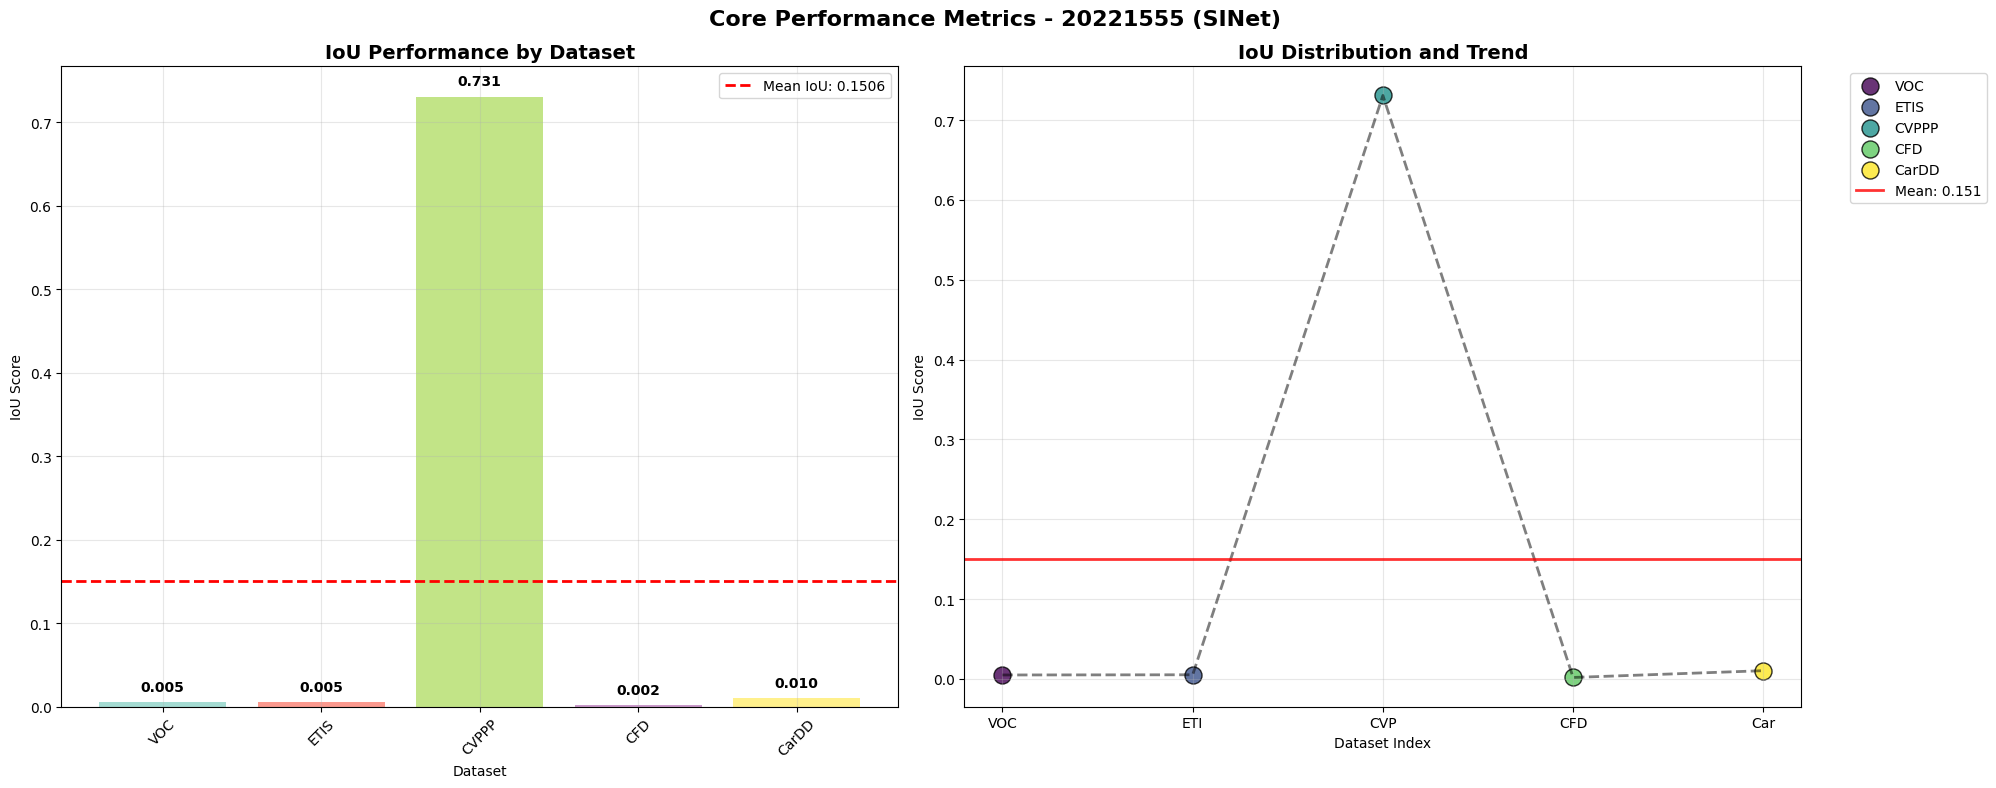

In [9]:
# ==================== 첫 번째 장: 핵심 지표 시각화 ====================
plt.figure(figsize=(20, 8))
plt.suptitle(f'Core Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 1-1. 각 데이터셋별 IoU (바 차트)
plt.subplot(1, 2, 1)
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))
bars = plt.bar(results_df['Dataset Name'], results_df['IoU'], color=colors, alpha=0.8)
plt.axhline(y=mean_iou, color='red', linestyle='--', linewidth=2, label=f'Mean IoU: {mean_iou:.4f}')
plt.title('IoU Performance by Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Dataset')
plt.ylabel('IoU Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, results_df['IoU']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 1-2. IoU 분포 (레이더 차트 스타일)
plt.subplot(1, 2, 2)
datasets = results_df['Dataset Name'].tolist()
iou_scores = results_df['IoU'].tolist()

# 색상 맵 생성
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))

for i, (dataset, iou, color) in enumerate(zip(datasets, iou_scores, colors)):
    plt.scatter(i, iou, s=150, c=[color], alpha=0.8, label=dataset, edgecolors='black', linewidth=1)

plt.plot(range(len(datasets)), iou_scores, 'k--', alpha=0.5, linewidth=2)
plt.axhline(y=mean_iou, color='red', linestyle='-', alpha=0.8, linewidth=2,
            label=f'Mean: {mean_iou:.3f}')
plt.title('IoU Distribution and Trend', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Index')
plt.ylabel('IoU Score')
plt.xticks(range(len(datasets)), [d[:3] for d in datasets])  # 줄여서 표시
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'core_performance_{Experiments_Time}.png')
plt.show()

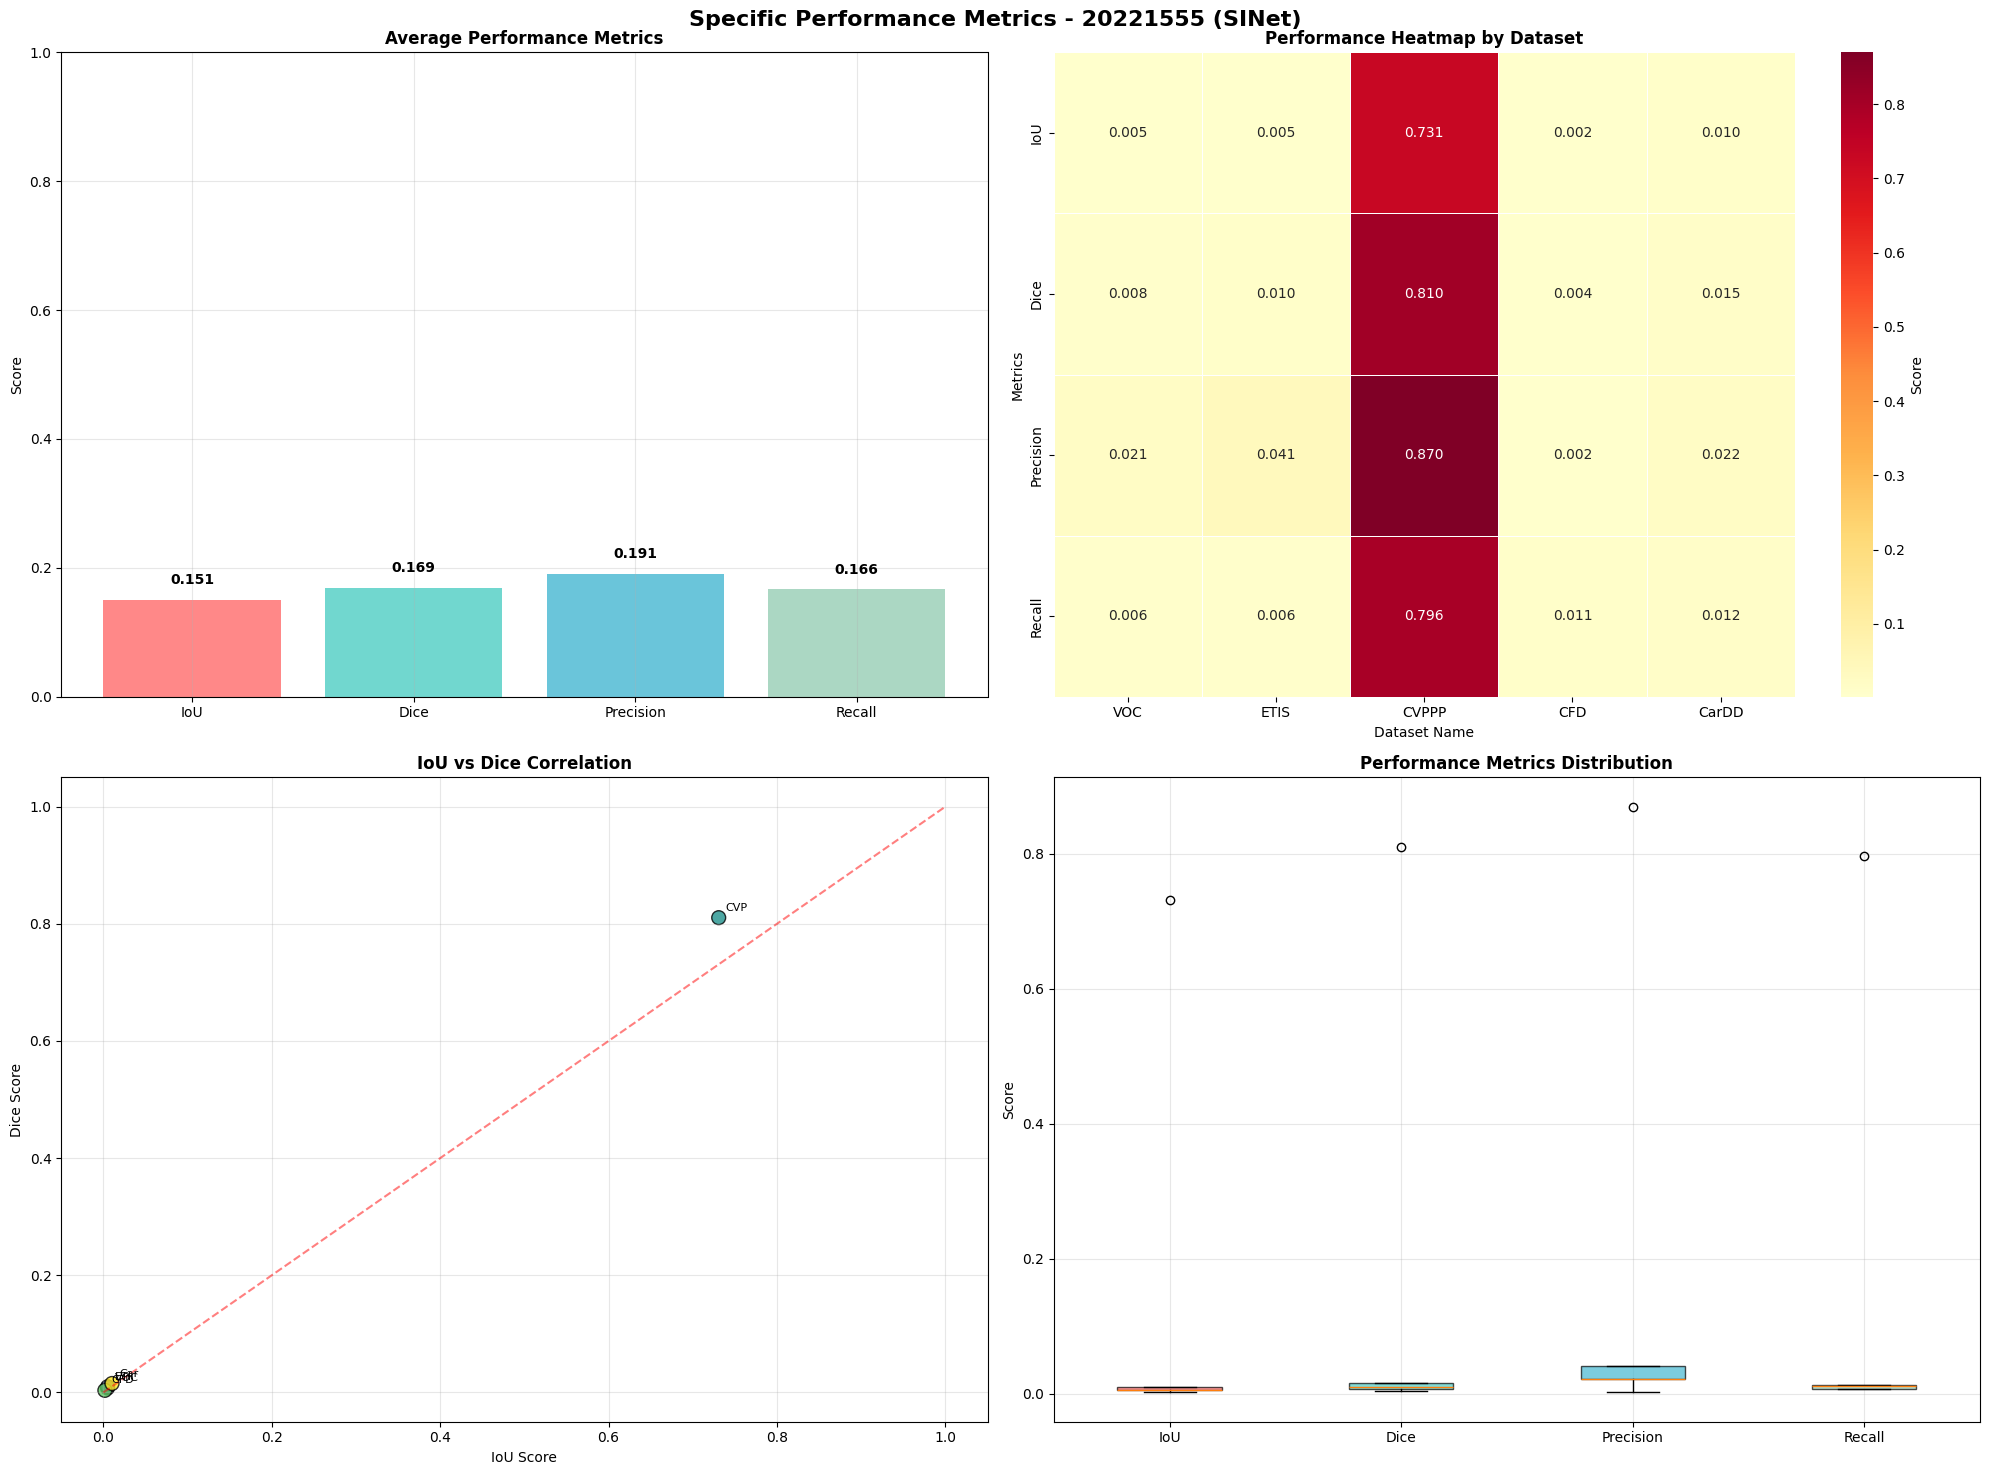

In [10]:
# ==================== 두 번째 장: 상세 분석 ====================
plt.figure(figsize=(20, 15))
plt.suptitle(f'Specific Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 2-1. 전체 성능 지표 비교
plt.subplot(2, 2, 1)
metrics = ['IoU', 'Dice', 'Precision', 'Recall']
values = [results_df[metric].mean() for metric in metrics]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Average Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2-2. 데이터셋별 성능 히트맵
plt.subplot(2, 2, 2)
heatmap_data = results_df[['IoU', 'Dice', 'Precision', 'Recall']].T
heatmap_data.columns = results_df['Dataset Name']

sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', 
            cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title('Performance Heatmap by Dataset', fontsize=12, fontweight='bold')
plt.ylabel('Metrics')

# 2-3. IoU vs Dice 상관관계
plt.subplot(2, 2, 3)
plt.scatter(results_df['IoU'], results_df['Dice'], c=range(len(results_df)), 
           cmap='viridis', s=100, alpha=0.8, edgecolors='black')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)  # 대각선
plt.xlabel('IoU Score')
plt.ylabel('Dice Score')
plt.title('IoU vs Dice Correlation', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 각 점에 데이터셋 이름 표시
for i, dataset in enumerate(results_df['Dataset Name']):
    plt.annotate(dataset[:3], (results_df['IoU'].iloc[i], results_df['Dice'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2-4. 성능 지표별 분포
plt.subplot(2, 2, 4)
metrics_data = []
metrics_labels = []
for metric in ['IoU', 'Dice', 'Precision', 'Recall']:
    metrics_data.append(results_df[metric].tolist())
    metrics_labels.append(metric)

box_plot = plt.boxplot(metrics_data, labels=metrics_labels, patch_artist=True)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Performance Metrics Distribution', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'detail_performance_{Experiments_Time}.png')
plt.show()


In [11]:
# === 마지막 셀: 실험 내역 요약 & Markdown 저장 (샘플 이미지, 그래프, Core/Detail CSV 테이블 포함) ===
import glob, importlib.util, torch
from pathlib import Path
from IPython.display import Markdown, display
import pandas as pd

# 1) Performance Metrics
metrics_summary = {
    'Mean IoU': mean_iou,
    'Mean Dice': results_df['Dice'].mean(),
    'Mean Precision': results_df['Precision'].mean(),
    'Mean Recall': results_df['Recall'].mean(),
    'Total Params': total_params
}

# 2) 샘플 이미지 (최대 4개)
sample_images = glob.glob(f"{vis_root}/*/*.png")[:4]

# 3) 분석용 그래프 이미지 (output_root/*.png)
graph_images = glob.glob(f"{output_root}/*.png")

# 4) Core & Detail CSV 경로 자동 탐색
csv_files = glob.glob(f"{output_root}/*.csv")
core_csv_path   = next((p for p in csv_files if 'core'   in Path(p).name.lower()), None)
detail_csv_path = next((p for p in csv_files if 'detail' in Path(p).name.lower()), None)

# 5) CSV 읽기
core_df   = pd.read_csv(core_csv_path)   if core_csv_path   else pd.DataFrame()
detail_df = pd.read_csv(detail_csv_path) if detail_csv_path else pd.DataFrame()

# 6) training_args.py 동적 로드
spec = importlib.util.spec_from_file_location('training_args', 'training_args.py')
training_args = importlib.util.module_from_spec(spec)
spec.loader.exec_module(training_args)

# 7) 더미 모델 생성 후 옵티마이저/스케줄러/손실 함수 인스턴스
class _Dummy(torch.nn.Module):
    def parameters(self): return [torch.nn.Parameter(torch.zeros(1))]
dummy = _Dummy()
opt     = training_args.Make_Optimizer(dummy)
sch     = training_args.Make_LR_Scheduler(opt)

# Binary와 Multiclass 두 경우 모두 생성
loss_fn_binary = training_args.Make_Loss_Function(2)    # Binary case (클래스 수 = 2)
loss_fn_multi  = training_args.Make_Loss_Function(21)   # Multiclass case (VOC 21클래스)

# 8) 하이퍼파라미터 추출
opt_params = {k: v for k,v in opt.defaults.items() if k in ('lr','momentum','weight_decay','betas','eps')}
sch_params = {
    'type':      sch.__class__.__name__,
    'T_max':     getattr(sch, 'T_max', None),
    'warmup':    getattr(sch, 'warmup_iters', None),
    'eta_min':   getattr(sch, 'eta_min', None),
    'power':     getattr(sch, 'power', None),
}
# Binary와 Multiclass loss function 정보 추출
def extract_loss_params(loss_fn, case_name):
    params = {'type': loss_fn.__class__.__name__, 'case': case_name}
    for attr in ('alpha','gamma','weight','ignore_index','mode'):
        if hasattr(loss_fn, attr):
            params[attr] = getattr(loss_fn, attr)
    return params

loss_params_binary = extract_loss_params(loss_fn_binary, 'Binary (2 classes)')
loss_params_multi = extract_loss_params(loss_fn_multi, 'Multiclass (21 classes)')

# 9) Markdown 조립
md_lines = [
    '# 📝 실험 내역 요약',
    '## ▶ Performance Metrics'
]
for k,v in metrics_summary.items():
    if k == 'Total Params':
        md_lines.append(f"- **{k}**: `{v:,}`")  # 쉼표 형식으로 표시
    else:
        md_lines.append(f"- **{k}**: `{v:.4f}`")

# 그래프 이미지
md_lines += ['', '## ▶ 분석용 그래프']
for img in graph_images:
    img_name = Path(img).name
    md_lines.append(f"![{img_name}]({img_name})")

# Core CSV 테이블
if not core_df.empty:
    md_lines += ['', '## ▶ Core Metrics']
    # DataFrame.to_markdown() 로 생성된 텍스트를 한 줄씩 추가
    md_lines += core_df.to_markdown(index=False).split('\n')

# Detail CSV 테이블
if not detail_df.empty:
    md_lines += ['', '## ▶ Detail Metrics']
    md_lines += detail_df.to_markdown(index=False).split('\n')

# Hyperparameters
md_lines += ['', '## ▶ Hyperparameters']
md_lines.append(f"### Optimizer ({opt.__class__.__name__})")
for k,v in opt_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"### Scheduler ({sch_params.pop('type')})")
for k,v in sch_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

# Loss Functions (Binary & Multiclass)
md_lines.append("### Loss Functions")

md_lines.append(f"#### Binary Case ({loss_params_binary.pop('type')})")
for k,v in loss_params_binary.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"#### Multiclass Case ({loss_params_multi.pop('type')})")
for k,v in loss_params_multi.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_text = '\n'.join(md_lines)

# 10) 화면에 출력
#display(Markdown(md_text))

# 11) Markdown 파일로 저장
output_dir = Path(output_root)
output_dir.mkdir(parents=True, exist_ok=True)
md_path = output_dir / f"experiment_summary_{Experiments_Time}.md"
md_path.write_text(md_text, encoding='utf-8')

print(f"✅ Markdown 요약이 저장되었습니다: {md_path}")


✅ Markdown 요약이 저장되었습니다: output/output_250613_021114/experiment_summary_250613_021114.md
